In [3]:
import yfinance as yf, pandas as pd, shutil, os, time, glob
import numpy as np
import requests
from get_all_tickers import get_tickers as gt
from statistics import mean
import talib
import matplotlib.pyplot as plt
import seaborn as sns 


# Get the path for each stock file in a list
list_files = (glob.glob("/Users/ks/bot/Pynance/yfinance/stock_data_min/*.csv"))


def indicator_rsi(stock, time_period=14):
    """
    Working of RSI
    - Observe the last 14 closing prices of a stock.
    - Determine whether the current time period's closing price is higher or lower than the previous one.
    - Calculate the average gain and loss over the last 14 time period's.
    - Compute the relative strength (RS): (AvgGain/AvgLoss)
    - Compute the relative strength index (RSI): (100–100 / ( 1 + RS))
    - TODO: time_period is variable (Neural network)

    Working with smoothed RSI
    - https://mrjbq7.github.io/ta-lib/doc_index.html
    - Compute the relative strength (RS): EMA smoothed
    """

    # Create the dataframe that we will be adding the final analysis of each stock to
    rsi_power = pd.DataFrame(columns=["Company", "Periods_Observed", "Crosses", "True_Positive", "False_Positive", "True_Negative", "False_Negative", "Sensitivity", "Specificity", "Accuracy", "TPR", "FPR"])
    
    # Dataframe to hold the historical data of the stock we are interested in.
    hist_data = pd.read_csv("/Users/ks/bot/Pynance/yfinance/stock_data_min/"+stock.upper()+".csv")
    # Name of company
    company = stock
    # Append the closing prices of a stock in prices list
    prices = []
    c = 0
    # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
    while c < len(hist_data):
        if hist_data.iloc[c,4] > float(2.00):
            prices.append(hist_data.iloc[c,4])
        c += 1

    i = 0
    up_prices=[]
    down_prices=[]
    #  Loop to hold up and down price difference 
    while i < len(prices):
        if i == 0:
            up_prices.append(0)
            down_prices.append(0)
        else:
            if (prices[i]-prices[i-1])>0:
                up_prices.append(prices[i]-prices[i-1])
                down_prices.append(0)
            else:
                down_prices.append(prices[i]-prices[i-1])
                up_prices.append(0)
        i += 1

    x = 0
    avg_gain = []
    avg_loss = []
    #  Loop to calculate the average gain and loss
    while x < len(up_prices):
        if x < time_period+1:
            avg_gain.append(0)
            avg_loss.append(0)
        else:
            sum_gain = 0
            sum_loss = 0
            y = x-time_period
            while y < x:
                sum_gain += up_prices[y]
                sum_loss += down_prices[y]
                y += 1
            avg_gain.append(sum_gain/time_period)
            avg_loss.append(abs(sum_loss/time_period))
        x += 1

    p = 0
    RS = []
    RSI = []
    #  Loop to calculate RSI and RS
    while p < len(prices):
        if p <time_period+1:
            RS.append(0)
            RSI.append(0)
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1+RSvalue)))
        p+=1

    #RSI_smoothed calculation
    RSI_smoothed = talib.RSI(np.asarray(prices), timeperiod=time_period)

    
    #  Creates the csv for each stock's RSI and price movements
    df_dict = {
        'Prices' : prices,
        'upPrices' : up_prices,
        'downPrices' : down_prices,
        'AvgGain' : avg_gain,
        'AvgLoss' : avg_loss,
        'RS' : RS,
        'RSI' : RSI,
        'RSI_smoothed' : RSI_smoothed
    }

    df_rsi = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI", "RSI_smoothed"])
    # df.to_csv("/Users/ks/bot/Pynance/rsi/rsi_data/"+company+"_RSI.csv", index = False)

    """
    Code to test the accuracy of the RSI at predicting stock prices
    -Initialize the variables we are using to measure accuracy.
    -Loop through each time period in a stocks historical data and see if the RSI crossed over the 30% or 70% line.
    -If a crossover did occur, check if the stock’s future price moved as expected.
    -Compute the measurement variables.
    """

    Days_Observed = time_period + 1
    Crosses = 0
    nothing = 0
    True_Positive = 0
    False_Positive = 0
    True_Negative = 0
    False_Negative = 0
    Sensitivity = 0
    Specificity = 0
    Accuracy = 0

    while Days_Observed < len(prices)-5:
        if RSI[Days_Observed] <= 30:
            if ((prices[Days_Observed + 1] + prices[Days_Observed + 2] + prices[Days_Observed + 3] + prices[Days_Observed + 4] + prices[Days_Observed + 5])/5) > prices[Days_Observed]:
                True_Positive += 1
            else:
                False_Negative += 1
            Crosses += 1
        elif RSI[Days_Observed] >= 70:
            if ((prices[Days_Observed + 1] + prices[Days_Observed + 2] + prices[Days_Observed + 3] + prices[Days_Observed + 4] + prices[Days_Observed + 5])/5) <= prices[Days_Observed]:
                True_Negative += 1
            else:
                False_Positive += 1
            Crosses += 1
        else:
            #Do nothing
            nothing+=1
        Days_Observed += 1

    try:
        Sensitivity = (True_Positive / (True_Positive + False_Negative)) 
    except ZeroDivisionError: 
        Sensitivity = 0
    try:
        Specificity = (True_Negative / (True_Negative + False_Positive)) 
    except ZeroDivisionError:
        Specificity = 0
    try:
        Accuracy = (True_Positive + True_Negative) / (True_Negative + True_Positive + False_Positive + False_Negative) 
    except ZeroDivisionError:
        Accuracy = 0

    # Calculate the true positive rate
    TPR = Sensitivity  
    # Calculate the false positive rate
    FPR = 1 - Specificity  

    # Create a row to add to the compare_stocks
    add_row = {'Company' : company, 'Periods_Observed' : Days_Observed, 'Crosses' : Crosses, 'True_Positive' : True_Positive, 'False_Positive' : False_Positive, 
    'True_Negative' : True_Negative, 'False_Negative' : False_Negative, 'Sensitivity' : Sensitivity, 'Specificity' : Specificity, 'Accuracy' : Accuracy, 'TPR' : TPR, 'FPR' : FPR}

    # Add the analysis on the stock to the existing Compare_Stocks dataframe
    df_rsi_power = rsi_power.append(add_row, ignore_index = True) 
    # compare_stocks.to_csv("/Users/ks/bot/Pynance/rsi/rsi_power/stock_analysis.csv", index = False)  

    return df_rsi, df_rsi_power


def indicator_bbands(stock, time_period=21):

    """
    - TODO: time_period is variable (Neural network)
    - Use BBands with diff for slope
    """
    # Dataframe to hold the historical data of the stock we are interested in.
    hist_data = pd.read_csv("/Users/ks/bot/Pynance/yfinance/stock_data_min/"+stock.upper()+".csv")
    # Name of company
    company = stock

    # Append the closing prices of a stock in prices list
    prices = []
    c = 0
    # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
    while c < len(hist_data):
        if hist_data.iloc[c,4] > float(2.00):
            prices.append(hist_data.iloc[c,4])
        c += 1

    upperband, middleband, lowerband = talib.BBANDS(hist_data['Close'], timeperiod=time_period, nbdevup=2, nbdevdn=2, matype=0)
    upperband_ema, middleband_ema, lowerband_ema = talib.BBANDS(hist_data['Close'], timeperiod=time_period, nbdevup=2, nbdevdn=2, matype=talib.MA_Type.T3)
    
    #  Creates the csv for each stock's bbands
    df_dict = {
        'Company' : company,
        'Prices' : prices,
        'upperband' : upperband,
        'lowerband' : lowerband,
        'middleband' : middleband,
        'upperband_ema' : upperband_ema,
        'lowerband_ema' : lowerband_ema,
        'middleband_ema' : middleband_ema,
    }

    df_bbands = pd.DataFrame(df_dict, columns = ['Company', 'Prices', 'upperband', 'lowerband', 'middleband','upperband_ema', 'lowerband_ema', "middleband_ema"])

    return df_bbands

In [5]:
def plots():
    stock = input('Enter Stock symbol: ')
    time_period = input('Enter desired time period for indicator: ')
    df_rsi, df_rsi_power = indicator_rsi(stock, time_period)
    df_bbands = indicator_bbands(stock, time_period)

list_files = (glob.glob("/Users/ks/bot/Pynance/yfinance/stock_data_min/*.csv"))
test = pd.read_csv("/Users/ks/bot/Pynance/yfinance/stock_data_min/CSCO.csv")
df_bbands = indicator_bbands('CSCO')
df_bbands['time'] = test['Datetime']
df_rsi, df_rsi_power = indicator_rsi('CSCO')


buy = []
sell = []
for i in range(len(df_rsi)):
    if df_rsi['RSI'][i] > 70:
        sell.append(df_rsi['Prices'][i])
        buy.append(np.nan)
    elif df_rsi['RSI'][i] < 30:
        sell.append(np.nan)
        buy.append(df_rsi['Prices'][i])
    else:
        buy.append(np.nan)
        sell.append(np.nan)


df_rsi['Buy_signal'] = buy
df_rsi['Sell_signal'] = sell


buy_bb = []
sell_bb = []
for i in range(len(df_bbands)):
    if df_bbands['Prices'][i] < df_bbands['lowerband'][i]:
        sell_bb.append(np.nan)
        buy_bb.append(df_bbands['Prices'][i])
    elif df_bbands['Prices'][i] > df_bbands['upperband'][i]:
        sell_bb.append(df_rsi['Prices'][i])
        buy_bb.append(np.nan)
    else:
        buy_bb.append(np.nan)
        sell_bb.append(np.nan)


df_bbands['Buy_signal'] = buy_bb
df_bbands['Sell_signal'] = sell_bb


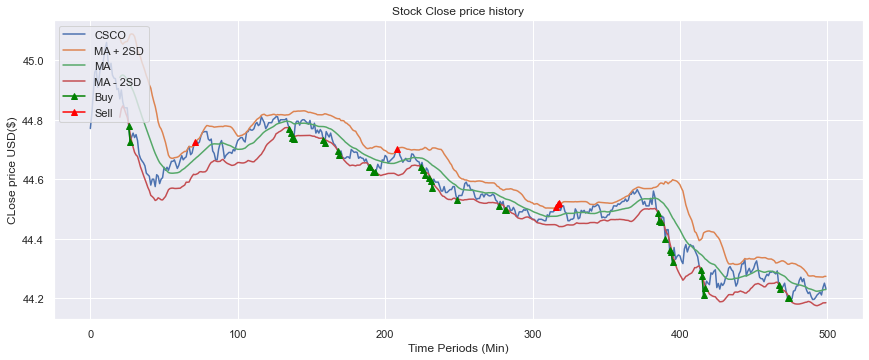

In [6]:
sns.set_theme()
vp = 500
plt.figure(figsize=(14.5,5.5))
plt.plot(test['Close'][:vp], label = 'CSCO')
plt.plot(df_bbands['upperband'][:vp], label = 'MA + 2SD')
plt.plot(df_bbands['middleband'][:vp], label = 'MA')
plt.plot(df_bbands['lowerband'][:vp], label = 'MA - 2SD')
plt.plot(list(range(0,500)),df_bbands['Buy_signal'][:vp], label = 'Buy', marker = '^', color = 'green')
plt.plot(list(range(0,500)),df_bbands['Sell_signal'][:vp], label = 'Sell', marker = '^', color = 'red')
plt.title('Stock Close price history')
plt.xlabel('Time Periods (Min)')
plt.ylabel('CLose price USD($)')
plt.legend(loc="upper left")
plt.show()

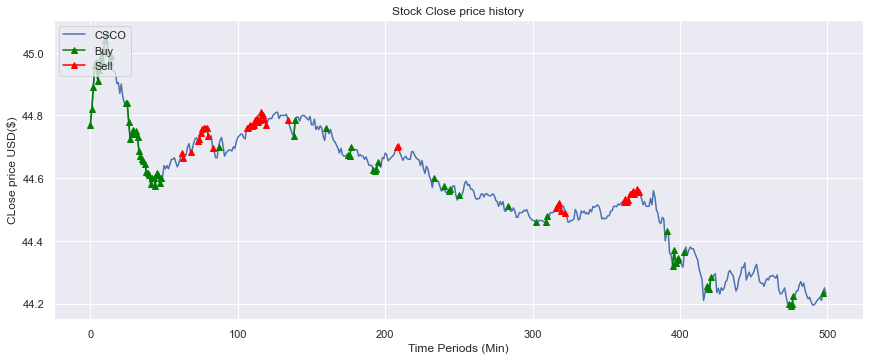

In [127]:
sns.set_theme()
vp = 500
plt.figure(figsize=(14.5,5.5))
plt.plot(test['Close'][:vp], label = 'CSCO')
plt.plot(list(range(0,500)),df_rsi['Buy_signal'][:vp], label = 'Buy', marker = '^', color = 'green')
plt.plot(list(range(0,500)),df_rsi['Sell_signal'][:vp], label = 'Sell', marker = '^', color = 'red')
plt.title('Stock Close price history')
plt.xlabel('Time Periods (Min)')
plt.ylabel('CLose price USD($)')
plt.legend(loc="upper left")
plt.show()

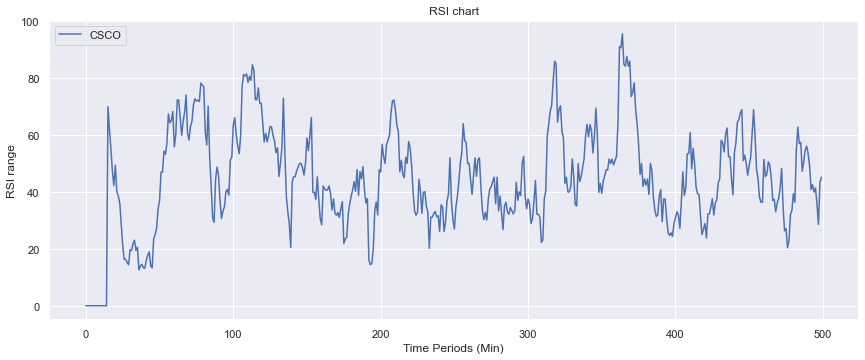

In [126]:
sns.set_theme()
vp = 500
plt.figure(figsize=(14.5,5.5))
plt.plot(df_rsi['RSI'][:vp], label = 'CSCO')
plt.title('RSI chart')
plt.xlabel('Time Periods (Min)')
plt.ylabel('RSI range')
plt.legend(loc="upper left")
plt.show()

0      44.770401
1      44.820000
2      44.889999
3      44.959999
4      44.970001
         ...    
495          NaN
496          NaN
497    44.235001
498          NaN
499          NaN
Name: Buy_signal, Length: 500, dtype: float64

In [132]:
df_overlap_buy = []
df_overlap_sell = []
for i in range(len(df_rsi)):
    if df_rsi['Buy_signal'][i] == df_bbands['Buy_signal'][i]:
        df_overlap_buy.append(df_rsi['Prices'][i])
    elif df_rsi['Sell_signal'][i] == df_bbands['Sell_signal'][i]:
        df_overlap_sell.append(df_rsi['Prices'][i])
    else:
        df_overlap_buy.append(np.nan)
        df_overlap_sell.append(np.nan)        


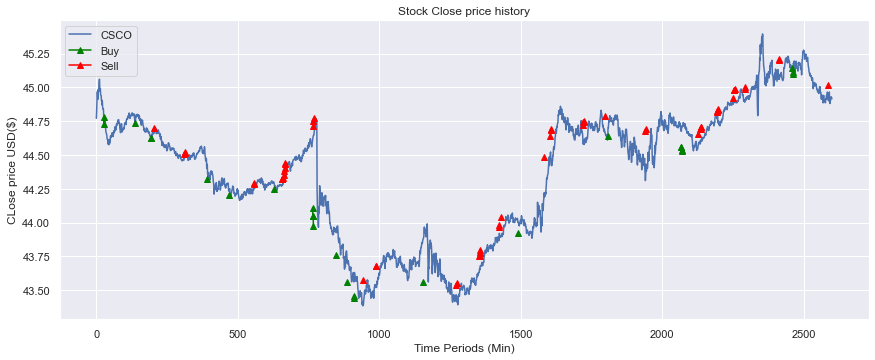

In [138]:
sns.set_theme()
vp = 2600
plt.figure(figsize=(14.5,5.5))
plt.plot(test['Close'][:vp], label = 'CSCO')
plt.plot(list(range(0,vp)),df_overlap_buy[:vp], label = 'Buy', marker = '^', color = 'green')
plt.plot(list(range(0,vp)),df_overlap_sell[:vp], label = 'Sell', marker = '^', color = 'red')
plt.title('Stock Close price history')
plt.xlabel('Time Periods (Min)')
plt.ylabel('CLose price USD($)')
plt.legend(loc="upper left")
plt.show()

In [181]:
from matplotlib import pyplot as plt

In [229]:
x_data = list(range(25,36))
y_data = list(np.random.randint(30000,70000,11))
y2_data = list(np.random.randint(30000,70000,11))
dev_y = list(np.random.randint(35000,70000,11))
new_dev_y = list(np.random.randint(35000,70000,11))

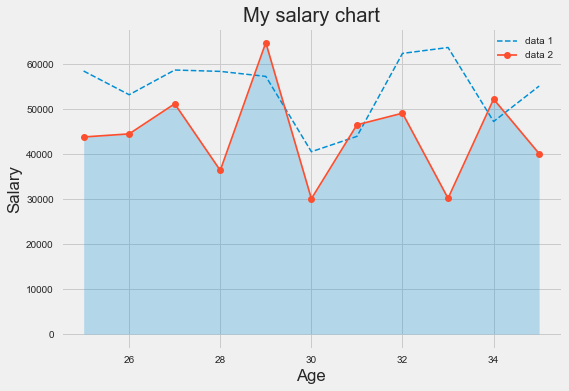

In [278]:
plt.style.use('fivethirtyeight')
plt.plot(x_data, y_data, linewidth=1.5, linestyle = '--', marker = 'x',label='data 1')
plt.plot(x_data, y2_data, linewidth=1.7, marker = 'o', label='data 2')

plt.title('My salary chart')
plt.xlabel('Age')
plt.ylabel('Salary')

plt.fill_between(x_data,y2_data, alpha=0.25)

plt.legend()
plt.show()

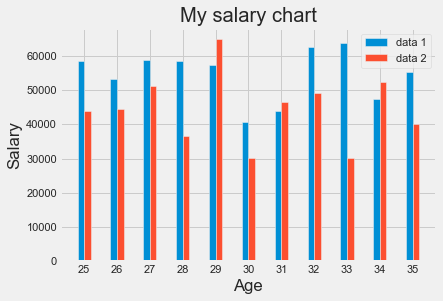

In [234]:
x_index = np.arange(len(x_data))
width = 0.2

plt.style.use('fivethirtyeight')

plt.bar(x_index-width/2, y_data, width = width, label='data 1')
plt.bar(x_index + width/2, y2_data,width = width, label='data 2')

plt.xticks(ticks=x_index, labels = x_data)
plt.title('My salary chart')
plt.xlabel('Age')
plt.ylabel('Salary')

plt.legend()
plt.show()

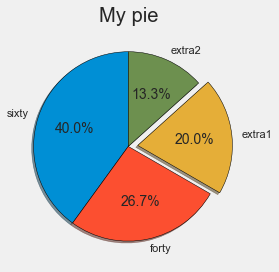

In [255]:
slices = [60,40, 30, 20]
labels = ['sixty', 'forty', 'extra1', 'extra2']
explode = [0,0,0.1,0]

plt.pie(slices, labels = labels, explode=explode, shadow=True, startangle=90, autopct='%1.1f%%' ,wedgeprops = {'edgecolor':'black'})

plt.title('My pie')
plt.tight_layout()
plt.show()

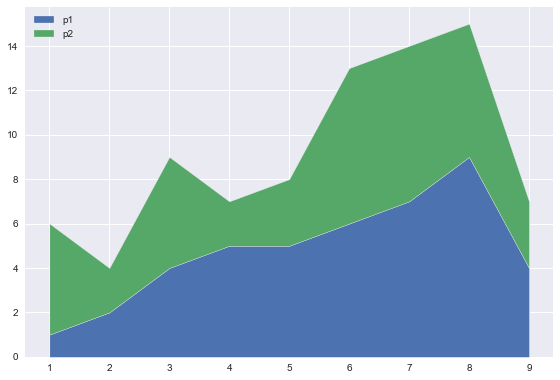

In [276]:
plt.style.use('seaborn')
minutes = np.arange(1,10)
p1 = [1,2,4,5,5,6,7,9,4]
p2 = [5,2,5,2,3,7,7,6,3]

labels = ['p1','p2']
plt.stackplot(minutes, p1, p2, labels = labels)
plt.tight_layout()
plt.legend(loc = 'upper left')
plt.show()


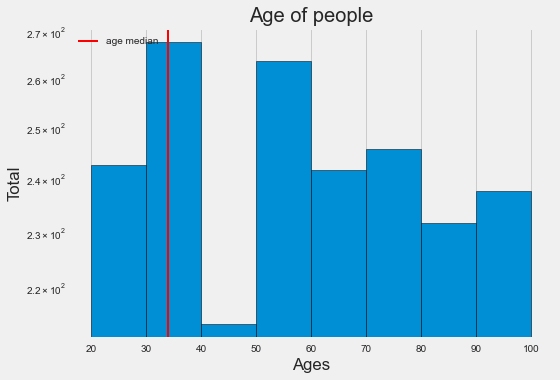

In [300]:
plt.style.use('fivethirtyeight')
ages = np.random.randint(18,100,2000)

bins = [20,30,40,50,60,70,80,90,100]
plt.hist(ages, bins=bins, edgecolor='black', log=True)

plt.axvline(34, color='red', label = 'age median', alpha= 1, linewidth=2)
plt.legend(loc='upper left')
plt.title('Age of people')
plt.xlabel('Ages')
plt.ylabel('Total')

plt.tight_layout()
plt.show()

In [327]:
x = np.random.randint(1,10,20)
y = np.random.randint(1,10,20)
colors = np.random.randint(1,10,20)
sizes  = np.random.randint(100,500,20)

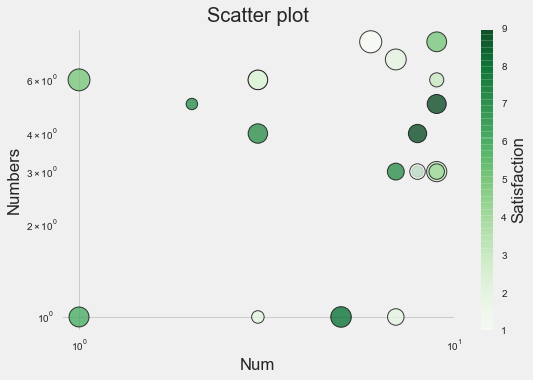

In [353]:
plt.scatter(x,y, s = sizes, c=colors, cmap='Greens', edgecolor='black', linewidth=1, alpha=0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Num')
plt.ylabel('Numbers')
cbar = plt.colorbar()
cbar.set_label('Satisfaction')
plt.title("Scatter plot")
plt.tight_layout()
plt.show()

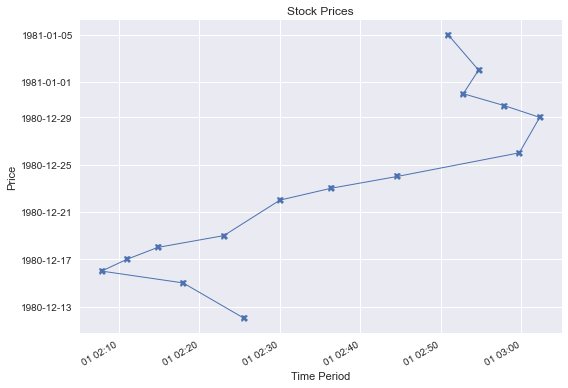

In [393]:
df_date = pd.read_csv('/Users/ks/bot/Pynance/yfinance/stock_data_daily/AAPL.csv')
df_date['Date'] = pd.to_datetime(df_date['Date'])
df_date.sort_values('Date', inplace=True)


price = df_date['Close'][:15]
date = df_date['Date'][:15]

plt.plot_date(price, date, linestyle='solid', linewidth=1, marker='X')
plt.gcf().autofmt_xdate()

plt.title('Stock Prices')
plt.xlabel('Time Period')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [370]:
x = []
y = []

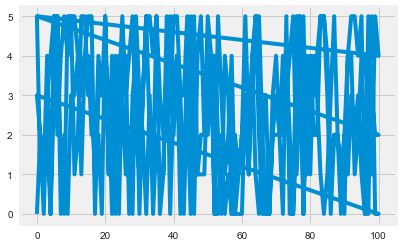

In [388]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from itertools import count
import random


index = count()

def animate(i):
    x.append(next(index))
    y.append(random.randint(0,5))
    
    plt.cla()
    plt.plot(x,y)

ani = FuncAnimation(plt.gcf(), animate, interval = 1000)



In [389]:
plt.style.use('seaborn')

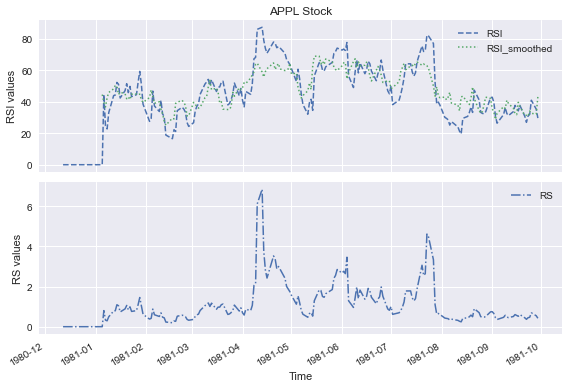

In [406]:
df = pd.read_csv('/Users/ks/bot/Pynance/rsi/rsi_data/AAPL_RSI.csv')
df_date['Date'] = pd.to_datetime(df_date['Date'])
df_date.sort_values('Date', inplace=True)

date = df_date['Date'][:200]
rsi = df['RSI'][:200]
rs = df['RS'][:200]
rsi_smooth = df['RSI_smoothed'][:200]

fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols = 1, sharex=True)

ax1.plot(date, rsi, linewidth=1.5, linestyle='--', label='RSI')
ax2.plot(date, rs, linewidth=1.5, linestyle='-.', label='RS')
ax1.plot(date, rsi_smooth, linewidth=1.5, linestyle=':', label='RSI_smoothed')

plt.gcf().autofmt_xdate()

ax1.legend()
ax1.set_title('APPL Stock')
# ax1.set_xlabel('Time')
ax1.set_ylabel('RSI values')

ax2.legend()
# ax2.set_title('APPL S?tock')
ax2.set_xlabel('Time')
ax2.set_ylabel('RS values')

plt.tight_layout()
plt.show()

# fig.savefig('rsi.png')